In [32]:
# Import all the necessary libraries.
import numpy as np
import timeit
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut

In [33]:
# Reset pseudo random generator to a known value so that results are reproducible.
np.random.seed(42)

In [34]:
# Example set size.
N = 10000

def true_func(N, typef):
    if(typef==0):
        return func0(N)
    else:
        return func0(N)
            
def func0(N):
    x = np.sort(6*np.random.rand(N) - 3)
    y = 0.5*x**2 + x + 2
    y_noisy = y + np.random.randn(N)
    # Create test set.
    x_test = np.linspace(-3, 3, 100).reshape(100, 1)
    y_noisy_test = 0.5*x_test**2 + x_test + 2 + np.random.randn(100, 1)
    include_bias = True
    # Polinomial degrees to be tested.
    degrees = [1, 2, 20]
    return x, y, y_noisy, x_test, y_noisy_test, include_bias, degrees

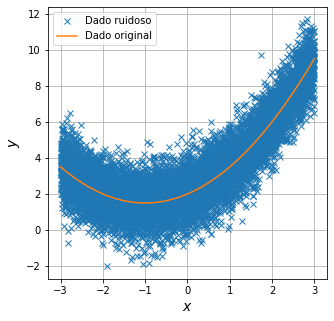

In [35]:
x, y, y_noisy, x_test, y_noisy_test, include_bias, degrees = true_func(N, 0)

# Plot original data versus noisy version.
fig = plt.figure(figsize=(5,5))
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
plt.plot(x, y, label='Dado original')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
#Show the plot.
plt.show()

In [36]:
# Reshape arrays so that they become column vectors.
x = x.reshape(N, 1)
y_noisy = y_noisy.reshape(N, 1)

# Holdout cross-validation

In [37]:
# Get timestamp of holdout start.
starttime = timeit.default_timer()

numOfSeeds = 10

maxOrder = 12

testSize = [0.3]

mse_val_vec = np.zeros((len(testSize), maxOrder))
mse_train_vec = np.zeros((len(testSize), maxOrder))

for t in range(0, len(testSize)):

    for d in range(1, maxOrder+1):
        # Instantiate a polynomial.
        poly = PolynomialFeatures(degree=d, include_bias=include_bias)
        # Instantiate a scaler.
        scaler = StandardScaler()
        # Instantiate a linear regressor.
        reg = LinearRegression()

        # Create a pipeline of actions.
        poly_reg = Pipeline([
            ("poly", poly),
            ("scaler", scaler),
            ("reg", reg),
        ])

        mse_val = np.zeros((numOfSeeds,))
        mse_train = np.zeros((numOfSeeds,))
        for s in range(0, numOfSeeds):

            # Split the whole set into random training and validation set.
            x_train, x_val, y_train, y_val = train_test_split(x, y_noisy, test_size=testSize[t], random_state=s)

            poly_reg.fit(x_train, y_train)

            y_val_predict = poly_reg.predict(x_val)

            y_train_predict = poly_reg.predict(x_train)

            mse_val[s] = mean_squared_error(y_val, y_val_predict)

            mse_train[s] = mean_squared_error(y_train, y_train_predict)

        mse_val_vec[t][d-1] = np.mean(mse_val)
        mse_train_vec[t][d-1] = np.mean(mse_train)

print("Tempo de execução: %1.4f [s]" % (timeit.default_timer() - starttime))

Tempo de execução: 1.6374 [s]


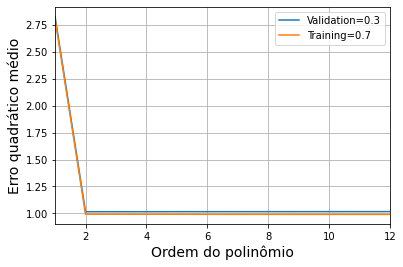

In [38]:
# Plot results.
#plt.figure(figsize=(15, 5))
plt.figure()

for t in range(0, len(testSize)): 
    
    ax = plt.subplot(1, len(testSize), t + 1)

    plt.plot(range(1, maxOrder+1), mse_val_vec[t],  label='Validation='+str(testSize[t]))
    plt.plot(range(1, maxOrder+1), mse_train_vec[t],  label='Training='+str(1-testSize[t]))
    plt.xlabel('Ordem do polinômio', fontsize=14)
    plt.ylabel('Erro quadrático médio', fontsize=14)
    plt.xticks(range(0, maxOrder+1, 2))
    plt.xlim([1, 12])
    plt.legend()
    plt.grid()

# Save figure
#plt.savefig("holdout_base_grande.png", dpi=600)
#Show the plot.
plt.show()

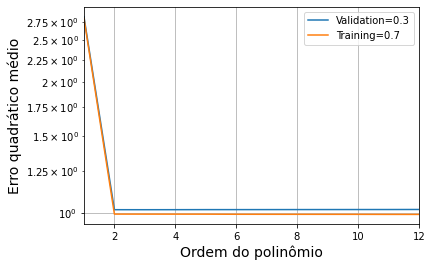

In [39]:
# Plot results.
#plt.figure(figsize=(15, 5))
plt.figure()

for t in range(0, len(testSize)): 
    
    ax = plt.subplot(1, len(testSize), t + 1)

    plt.plot(range(1, maxOrder+1), mse_val_vec[t],  label='Validation='+str(testSize[t]))
    plt.plot(range(1, maxOrder+1), mse_train_vec[t],  label='Training='+str(1-testSize[t]))
    plt.yscale('log')
    plt.xlabel('Ordem do polinômio', fontsize=14)
    plt.ylabel('Erro quadrático médio', fontsize=14)
    plt.xticks(range(0, maxOrder+1, 2))
    plt.xlim([1, 12])
    plt.legend()
    plt.grid()

# Save figure
plt.savefig("holdout_base_grande.png", dpi=600)
#Show the plot.
plt.show()

# k-fold cross-validation (k=2, 5, 10)

In [40]:
# Get timestamp of holdout start.
starttime = timeit.default_timer()

numOfSeeds = 10

maxOrder = 12

kSize = [10]

mse_val_vec = np.zeros((len(kSize), maxOrder))
std_val_vec = np.zeros((len(kSize), maxOrder))

for k in range(0, len(kSize)):

    for d in range(1, maxOrder+1):
        # Instantiate a polynomial.
        poly = PolynomialFeatures(degree=d, include_bias=include_bias)
        # Instantiate a scaler.
        scaler = StandardScaler()
        # Instantiate a linear regressor.
        reg = LinearRegression()

        # Create a pipeline of actions.
        poly_reg = Pipeline([
            ("poly", poly),
            ("scaler", scaler),
            ("reg", reg),
        ])

        mse_vec = np.zeros((numOfSeeds,))
        std_vec = np.zeros((numOfSeeds,))
        for s in range(0, numOfSeeds):

            # Instantiate the k-Fold object.
            kfold = KFold(n_splits=kSize[k], shuffle=True, random_state=s)
                        
            lin_scores = cross_val_score(poly_reg, x, y_noisy, scoring='neg_mean_squared_error', cv=kfold)

            scores = -lin_scores
            mse_vec[s] = scores.mean()
            std_vec[s] = scores.std()
            
        mse_val_vec[k][d-1] = np.mean(mse_vec)
        std_val_vec[k][d-1] = np.mean(std_vec)

print("Tempo de execução: %1.4f [s]" % (timeit.default_timer() - starttime))

Tempo de execução: 15.1107 [s]


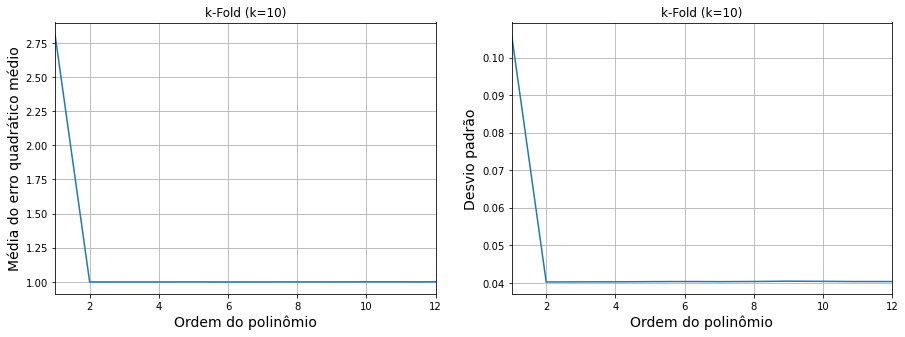

In [42]:
# Plot results.

for k in range(0, len(kSize)): 
    plt.figure(figsize=(15, 5))
    
    ax = plt.subplot(1, 2, 1)
    plt.plot(range(1, 13), mse_val_vec[k])
    plt.xlabel('Ordem do polinômio', fontsize=14)
    plt.ylabel('Média do erro quadrático médio', fontsize=14)
    plt.xticks(range(0, 13, 2))
    plt.xlim([1, 12])
    plt.title('k-Fold (k='+str(kSize[k])+')')
    plt.grid()

    ax = plt.subplot(1, 2, 2)
    plt.plot(range(1, 13), std_val_vec[k])
    plt.xlabel('Ordem do polinômio', fontsize=14)
    plt.ylabel('Desvio padrão', fontsize=14)
    plt.xticks(range(0, 13, 2))
    plt.xlim([1, 12])
    plt.title('k-Fold (k='+str(kSize[k])+')')
    plt.grid()

# Save figure
plt.savefig("kfold_base_grande.png", dpi=600)
#Show the plot.
plt.show()

# Leave-one-out cross-validation

In [11]:
# Get timestamp of holdout start.
starttime = timeit.default_timer()

# Instantiate the LOOCV object.
loocv = LeaveOneOut()

mean_vec = []
std_vec = []
for d in range(1, 13):
    # Instantiate a polynomial.
    poly = PolynomialFeatures(degree=d, include_bias=include_bias)
    # Instantiate a scaler.
    scaler = StandardScaler()
    # Instantiate a linear regressor.
    reg = LinearRegression()

    # Create a pipeline of actions.
    poly_reg = Pipeline([
        ("polys", poly),
        ("scaler", scaler),
        ("reg", reg),
    ])

    lin_scores = cross_val_score(poly_reg, x, y_noisy, scoring='neg_mean_squared_error', cv=loocv)
        
    scores = -lin_scores
    mean_vec.append(scores.mean())
    std_vec.append(scores.std())
    
print("Tempo de execução: %1.4f [s]" % (timeit.default_timer() - starttime))

Tempo de execução: 19.8732 [s]


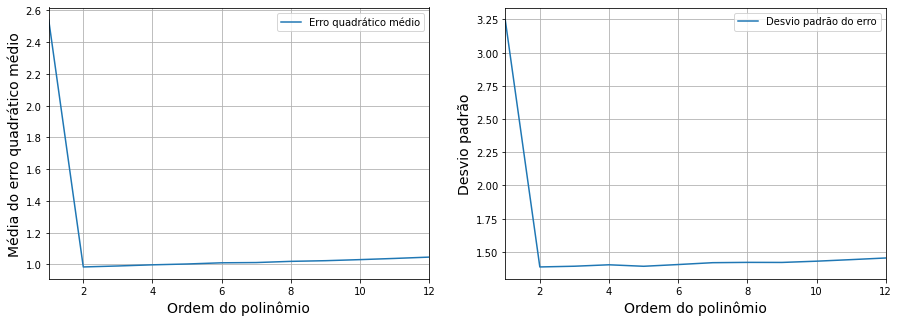

In [12]:
# Plot results.
plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
plt.plot(range(1, 13), mean_vec,  label='Erro quadrático médio')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Média do erro quadrático médio', fontsize=14)
#plt.yscale('log')
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
#plt.ylim([0.78, 0.81])
plt.legend()
plt.grid()

ax = plt.subplot(1, 2, 2)
plt.plot(range(1, 13), std_vec,  label='Desvio padrão do erro')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Desvio padrão', fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.legend()
plt.grid()

# Save figure
#plt.savefig("leave_one_out.png", dpi=600)
#Show the plot.
plt.show()

# Leave-P-Out (p=2)

In [13]:
# Get timestamp of holdout start.
starttime = timeit.default_timer()

# Instantiate the LPOCV object.
lpocv = LeavePOut(p=2)

mean_vec = []
std_vec = []
for d in range(1, 13):
    # Instantiate a polynomial.
    poly = PolynomialFeatures(degree=d, include_bias=include_bias)
    # Instantiate a scaler.
    scaler = StandardScaler()
    # Instantiate a linear regressor.
    reg = LinearRegression()

    # Create a pipeline of actions.
    poly_reg = Pipeline([
        ("poly", poly),
        ("scaler", scaler),
        ("reg", reg),
    ])

    lin_scores = cross_val_score(poly_reg, x, y_noisy, scoring='neg_mean_squared_error', cv=lpocv)
        
    scores = -lin_scores
    mean_vec.append(scores.mean())
    std_vec.append(scores.std())
    
print("Tempo de execução: %1.4f [s]" % (timeit.default_timer() - starttime))

Tempo de execução: 2747.3587 [s]


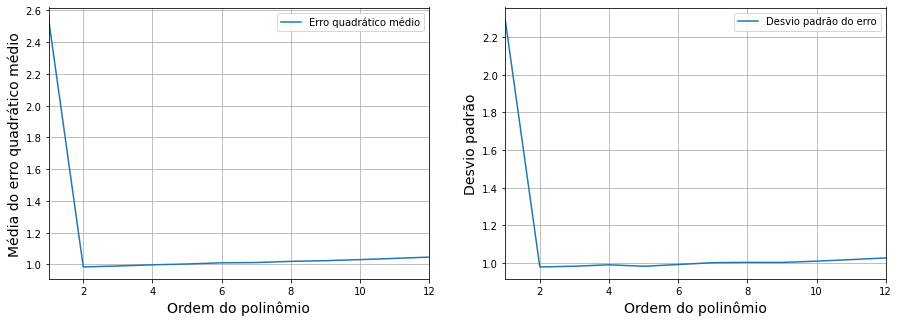

In [14]:
# Plot results.
plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
plt.plot(range(1, 13), mean_vec,  label='Erro quadrático médio')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Média do erro quadrático médio', fontsize=14)
#plt.yscale('log')
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
#plt.ylim([0.78, 0.81])
plt.legend()
plt.grid()

ax = plt.subplot(1, 2, 2)
plt.plot(range(1, 13), std_vec,  label='Desvio padrão do erro')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Desvio padrão', fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.legend()
plt.grid()

# Save figure
#plt.savefig("leave_one_out.png", dpi=600)
#Show the plot.
plt.show()